# Script description
### Input
* MongoDB database provided by Michiel Aernouts. This database contains metadata of the Belair sensors installed on bpost vans using the LoRa network. 
* This database contains the following elements:
    * _id: this is a unique ID generated for this packet 
    * device: unique ID for the device that sent the packet 
    * gateways: a list of the gateways that picked up the packet with their respective parameters (max 3) 
    * gpsLat and gpsLon: location 
    * hdop: measure for the correctness of the location 
    * rx_time: time of reception of the packet 
    * seqNumber: sequence number for the packets 
    * spfact: Spreading factor
* Sensor data of 16 different sensors that are mounted on the bpost vans and that are saved locally

### Output
This script loads the data, extends the features, explores the data more thoroughly and merges both data sets.

# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import pymongo
from pymongo import MongoClient
import folium
import json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
from matplotlib import pyplot as plt
import time
import datetime
from datetime import datetime
from datetime import timedelta  
from selenium import webdriver
from scipy import special, optimize
from IPython.display import Math
import math
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
import bokeh.plotting as bpl
import bokeh.models as bmo
from bokeh.palettes import d3
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from bokeh.io import export_png
from math import isnan

print("Pymongo version: " + pymongo.__version__)

Pymongo version: 3.7.2


# Metadata

## Load data
### Base data

In [2]:
client = MongoClient('localhost', 27017)
db = client.Belair
collection = db.data
# Extract data, sort by timestamp and reset indexes
base_df = pd.DataFrame(list(collection.find())).reset_index(drop=True)
print(len(base_df))
base_df.head()

193008


,_id,device,gateways,gpsLat,gpsLon,hdop,rx_time,seqNumber,spfact
0,5c17af0d4fa20f164de4b0bb,3432333852378918,"[{'rssi': -93, 'esp': -93.461838, 'snr': 10, '...",51.194618,4.418419,0.66,2018-12-17 14:13:33.410,54916,7
1,5c17af2d4fa20f164de4b0c7,3432333852378918,"[{'rssi': -104, 'esp': -104.331955, 'snr': 11,...",51.194618,4.418417,0.69,2018-12-17 14:14:04.616,54917,7
2,5c17af424fa20f164de4b0cf,3432333864377C18,"[{'rssi': -110, 'esp': -111.764351, 'snr': 3, ...",51.215313,4.408513,1.02,2018-12-17 14:14:26.937,8823,8
3,5c17af4d4fa20f164de4b0d4,3432333852378918,"[{'rssi': -107, 'esp': -107.973228, 'snr': 6, ...",51.194614,4.418419,0.74,2018-12-17 14:14:36.499,54918,7
4,5c17af604fa20f164de4b0df,3432333851378918,"[{'rssi': -114, 'esp': -119.455406, 'snr': -4,...",51.241817,4.430120,0.66,2018-12-17 14:14:56.056,48522,7


In [3]:
df = base_df.drop(columns=['_id', 'gateways', 'hdop']).sort_values('rx_time')
df.head()

,device,gpsLat,gpsLon,rx_time,seqNumber,spfact
0,3432333852378918,51.194618,4.418419,2018-12-17 14:13:33.410,54916,7
37000,3432333855378A18,51.215122,4.413489,2018-12-17 14:13:47.826,15652,7
1,3432333852378918,51.194618,4.418417,2018-12-17 14:14:04.616,54917,7
37001,3432333855378A18,51.215408,4.413910,2018-12-17 14:14:19.768,15653,7
2,3432333864377C18,51.215313,4.408513,2018-12-17 14:14:26.937,8823,8


### Extra data

In [4]:
# working_days = pd.read_excel (r'C:\Users\JeffG\Documents\Thesis\bpost_working_days.xlsx')
working_days = pd.read_excel (r'D:\Documents\Thesis\Case 2 - data\data\bpost_working_days.xlsx')
working_days['date'] = pd.to_datetime(working_days['date'])
print(working_days.dtypes)
working_days.head()

date           datetime64[ns]
working day             int64
dtype: object


,date,working day
0,2018-12-17,1
1,2018-12-18,1
2,2018-12-19,1
3,2018-12-20,1
4,2018-12-21,1


## Data extension

In [5]:
def extend_df(df):
    # Sort
    #df2 = df.sort_values(['device','rx_time'],ascending=[False,True]).reset_index()    
    df2 = df.sort_values(['device'],ascending=[False]).reset_index()
    df2 = df2.sort_values(['rx_time'],ascending=[True]).reset_index()
    
    # Add day-of-the-week columns
    df2['day_of_week'] = df2['rx_time'].dt.day_name()
    
    # Add separate time and date columns
    df2['time'] = df2['rx_time'].dt.time
    df2['date'] = df2['rx_time'].dt.date
    df2['date'] = pd.to_datetime(df2['date'])
    
    # Calculate time differences based on the device IDs 
    IPT = df2.groupby('device')['rx_time'].diff()
    
    # Check if the SPF changed
    same_spfact = df2.groupby('device')['spfact'].apply(lambda x : x==x.shift())
    
    # Check how much the SPF changed
    spfact_diff = df2.groupby('device')['spfact'].apply(lambda x : x-x.shift())
    
    # Add column with SPF of previous packet
    prev_spfact = df2.groupby('device')['spfact'].shift()
    
    # Add the new columns to the previous data frame
    df2 = df2.assign(IPT=pd.Series(IPT.values))
    df2['IPT'] = df2['IPT'].astype('timedelta64[s]')
    df2 = df2.assign(same_spfact=pd.Series(same_spfact.values))
    df2 = df2.assign(spfact_diff=pd.Series(spfact_diff.values))
    df2 = df2.assign(prev_spfact=pd.Series(prev_spfact.values))
    # Drop the rows with NaT-value
    df2 = df2.dropna(subset=['IPT'])
    df2 = df2.drop(columns=['index', 'level_0'], axis=1)
    
    return df2

In [6]:
# Extend with new features
df_ = extend_df(df)
# Merge with working days table
# df_ = pd.merge(df_, working_days, on='date')
df_.head()

,device,gpsLat,gpsLon,rx_time,seqNumber,spfact,day_of_week,time,date,IPT,same_spfact,spfact_diff,prev_spfact
2,3432333852378918,51.194618,4.418417,2018-12-17 14:14:04.616,54917,7,Monday,14:14:04.616000,2018-12-17,31.0,True,0.0,7.0
3,3432333855378A18,51.215408,4.413910,2018-12-17 14:14:19.768,15653,7,Monday,14:14:19.768000,2018-12-17,31.0,True,0.0,7.0
5,3432333852378918,51.194614,4.418419,2018-12-17 14:14:36.499,54918,7,Monday,14:14:36.499000,2018-12-17,31.0,True,0.0,7.0
6,3432333855378A18,51.215408,4.413912,2018-12-17 14:14:51.045,15654,7,Monday,14:14:51.045000,2018-12-17,31.0,True,0.0,7.0
8,3432333852378918,51.194611,4.418422,2018-12-17 14:15:07.931,54919,7,Monday,14:15:07.931000,2018-12-17,31.0,True,0.0,7.0


## Data visualization

### IPT vs time (per device)

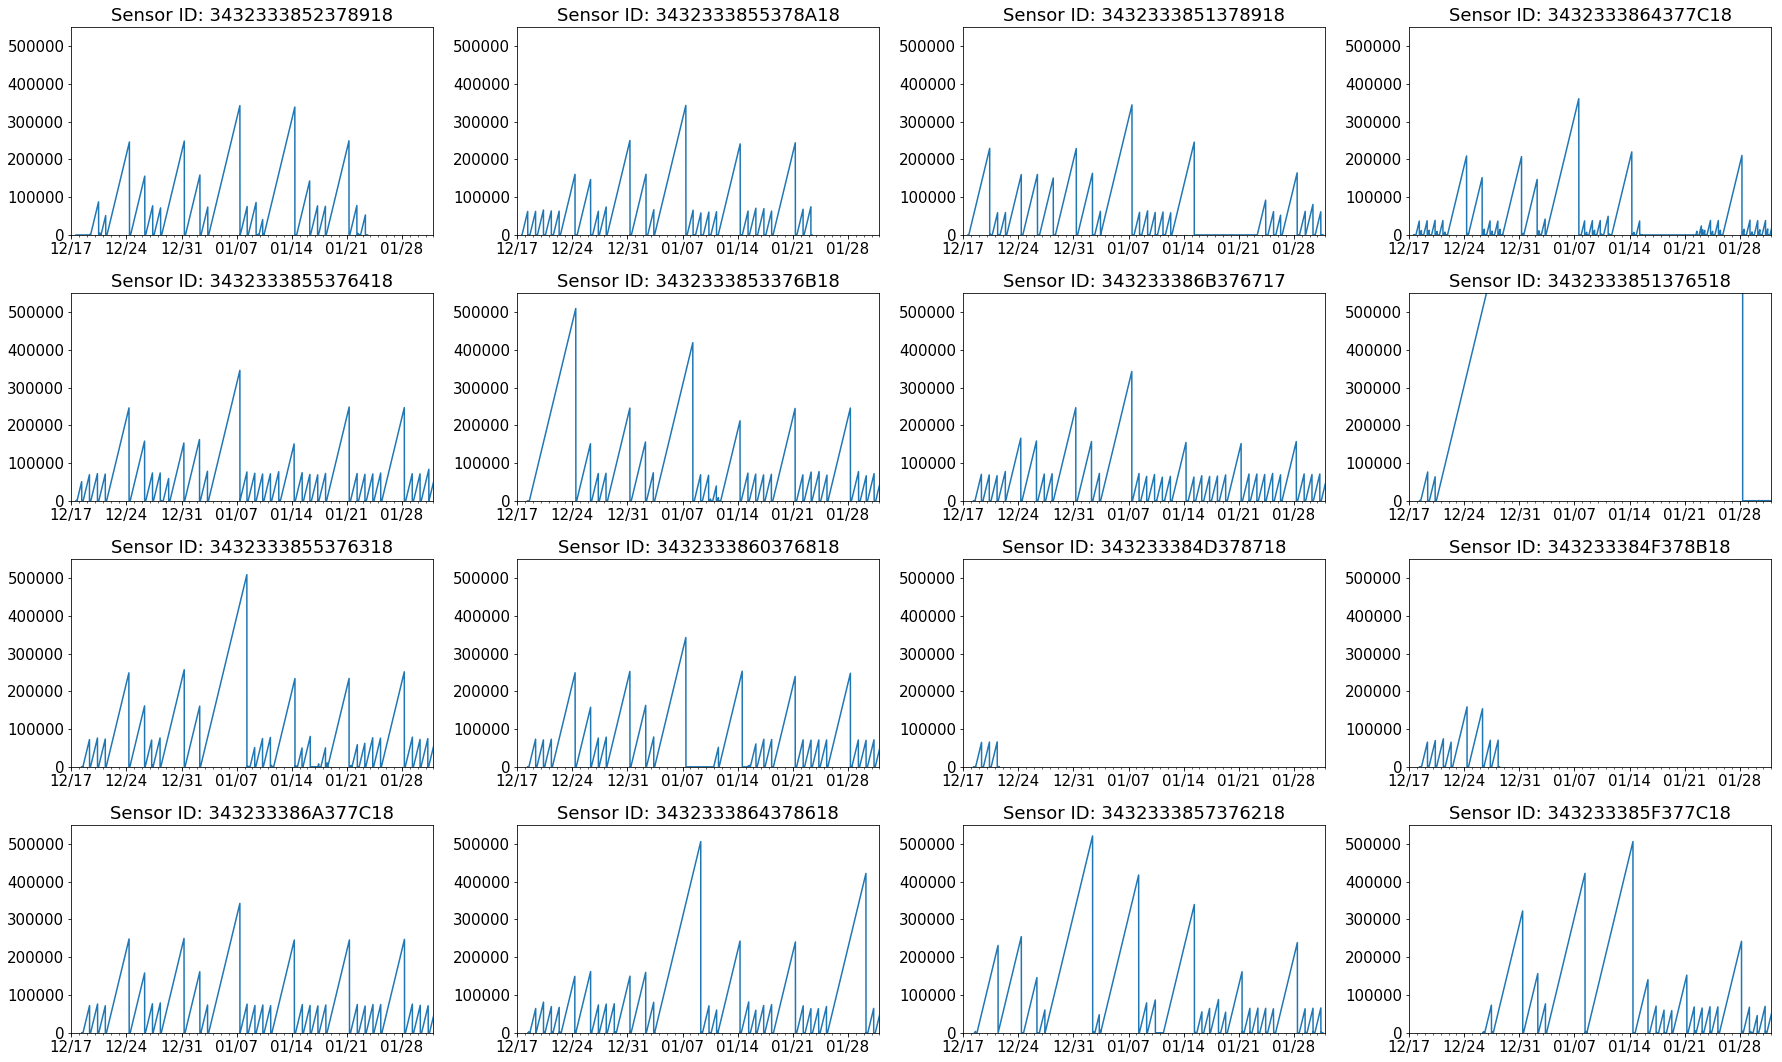

In [7]:
import datetime
import matplotlib.dates as mdates
categories = df_['device'].unique()
# z = working_days[(working_days['working day'] == 1)]
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(25,15))

mondays = mdates.WeekdayLocator(mdates.MONDAY)        # major ticks on the mondays
alldays = mdates.DayLocator()
weeksFmt = mdates.DateFormatter('%m/%d')

for c,num in zip(categories, range(1,len(categories)+1)):
    df0=df_[df_['device']==c]
    ax = fig.add_subplot(4, 4, num)
    ax.plot(df0['rx_time'], df0[['IPT']])
    ax.set_title("Sensor ID: " + str(c))
    ax.set_xlim([datetime.date(2018, 12, 17), datetime.date(2019, 2, 1)])
    ax.set_ylim(0,550000)

    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weeksFmt)
    
    # Plot working days
    #for xc in z.date.values:
    #    plt.axvline(x=xc, color='r', linestyle='-')

plt.tight_layout()
plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air\Results' + '/CH4_metadata_IPT_time.png')
plt.show()

### IPT vs time (for one device)

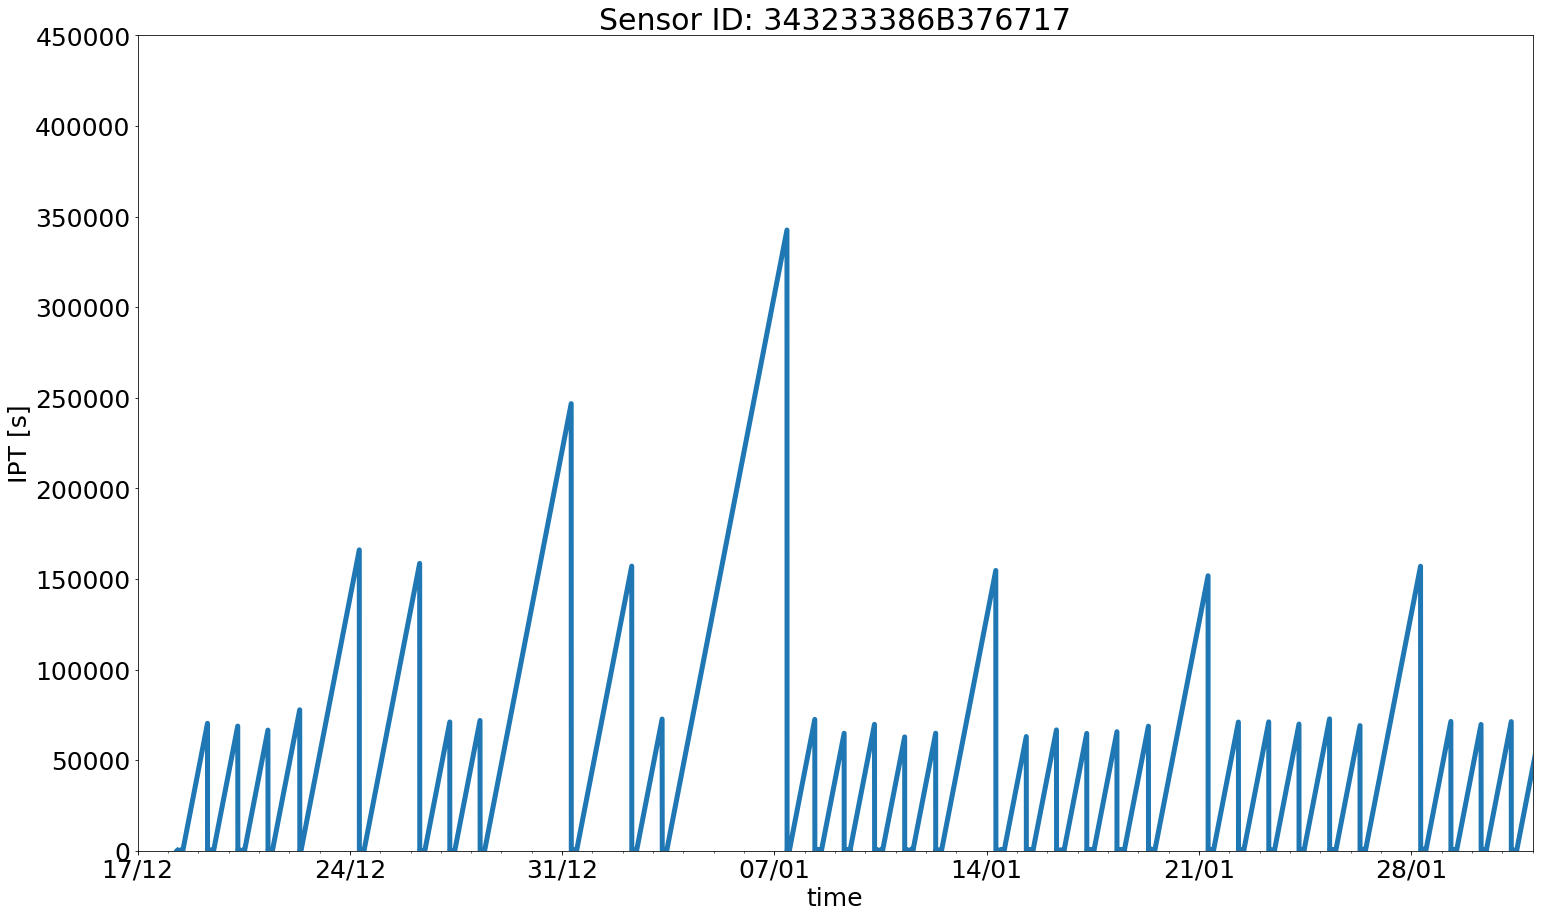

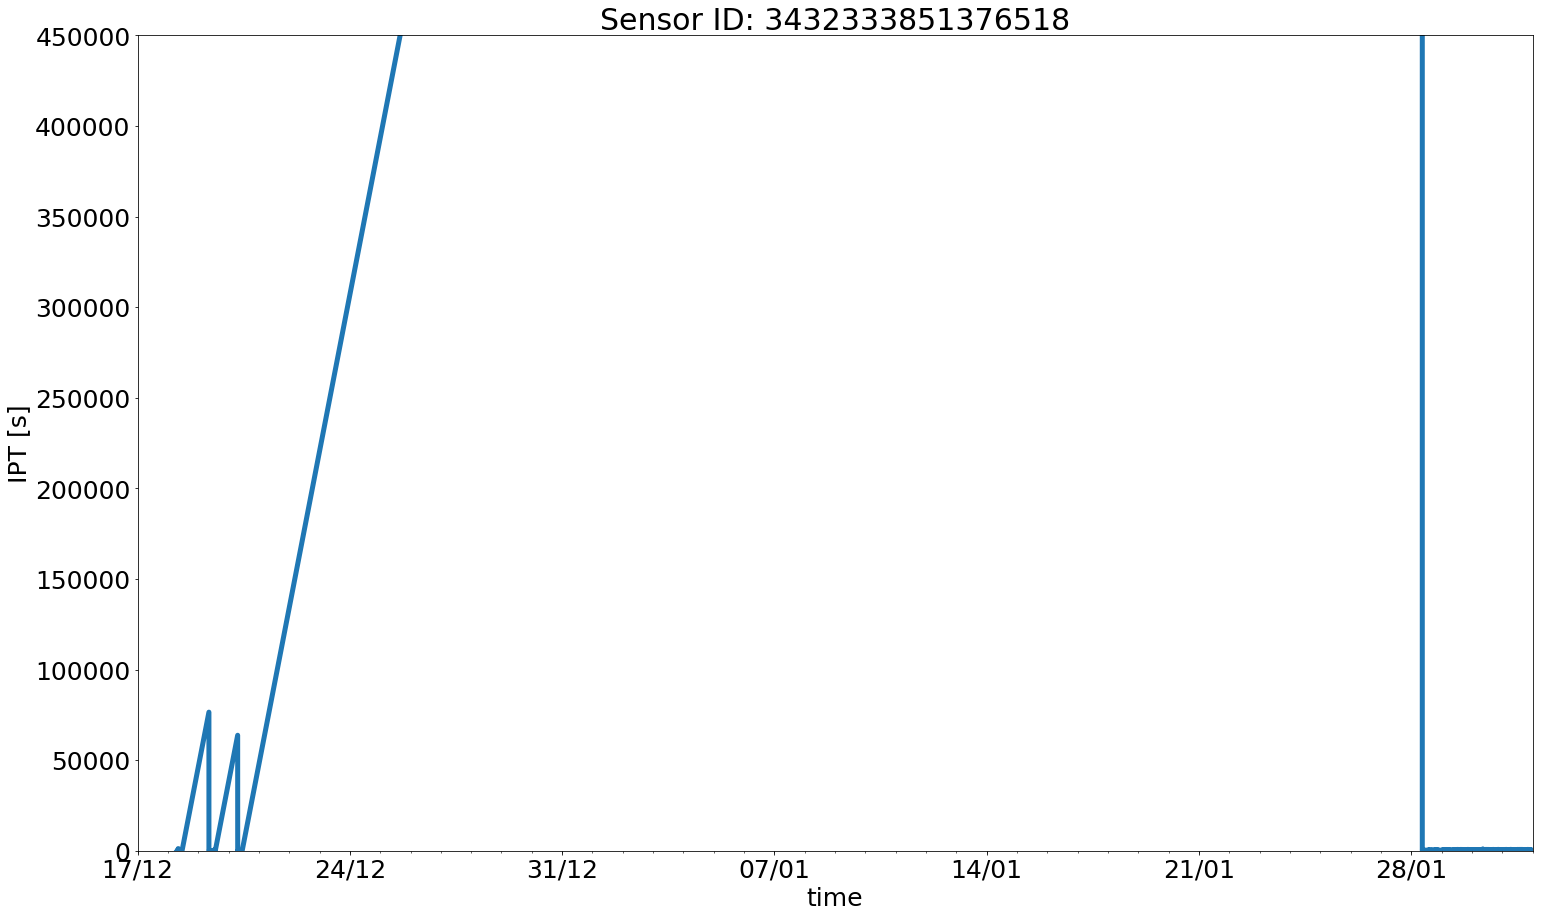

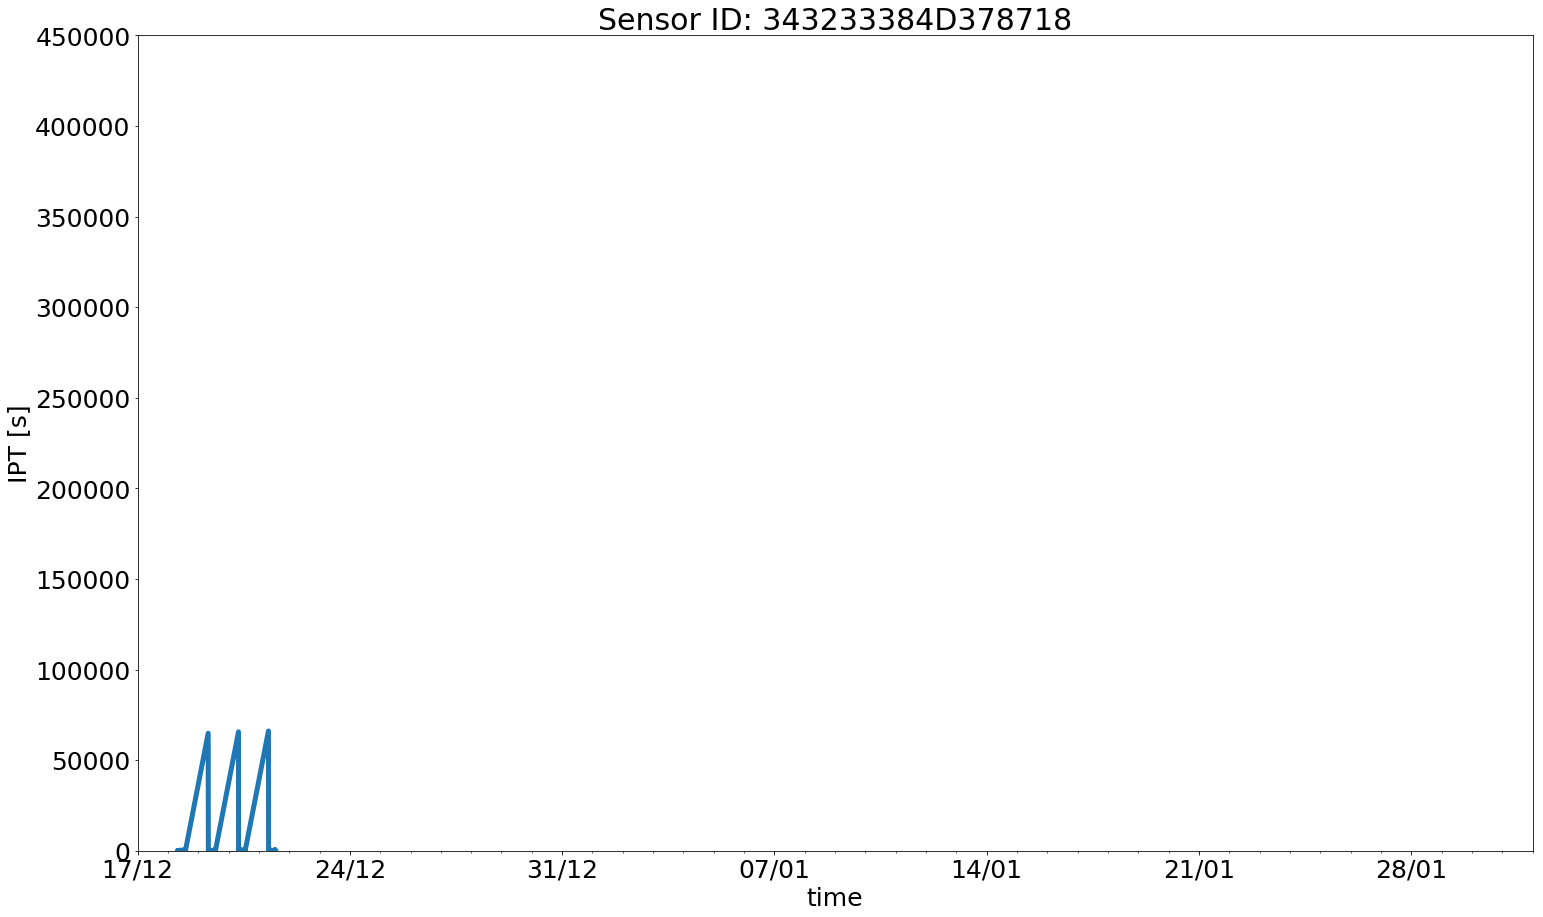

In [29]:
cs = ['343233386B376717','3432333851376518','343233384D378718']
plt.rcParams.update({'font.size': 25})

for c in cs:
    fig = plt.figure(figsize=(25,15))

    mondays = mdates.WeekdayLocator(mdates.MONDAY)        # major ticks on the mondays
    alldays = mdates.DayLocator()
    weeksFmt = mdates.DateFormatter('%d/%m')

    df0=df_[df_['device']==c]

    plt.title("Sensor ID: " + str(c))
    plt.xlim([datetime.date(2018, 12, 17), datetime.date(2019, 2, 1)])
    plt.ylim(0,450000)
    plt.ylabel('IPT [s]')
    plt.xlabel('time')

    plt.gca().xaxis.set_major_locator(mondays)
    plt.gca().xaxis.set_minor_locator(alldays)
    plt.gca().xaxis.set_major_formatter(weeksFmt)

    plt.plot(df0['rx_time'], df0[['IPT']],linewidth=5)
    plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air\Results\Data exploration'+'/CH4_IPT_time_'+str(c)+'.png')

In [9]:
device_ids = base_df['device'].unique()

# Sensor data

## Check number of values for each metric

In [10]:
metricsList = ['airquality.no2', 'airquality.o3', 'airquality.pm1', 'airquality.pm10', 
               'airquality.pm25', 'environment.relativehumidity', 'environment.temperature']
sizes = pd.DataFrame(columns=metricsList, index=device_ids)
for thingID in device_ids:
    path = r'D:\Documents\Thesis\Case 2 - data\data/lora.' + thingID
    df_1 = df[df['device']== thingID]
    occ = len(df_1)
    first_timestamp = df_1.iloc[0].rx_time; #print(first_timestamp)
    last_timestamp = df_1.iloc[-1].rx_time; #print(last_timestamp)
    for metricID in metricsList:
        df_2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + str(metricID) +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
        df_2['time'] = pd.to_datetime(df_2['time'], unit='ms')
        #Filter out data points that are outside the boundaries of the metadata
        df_2 = df_2[(df_2['time']>first_timestamp) & (df_2['time']<last_timestamp)]
        sizes.loc[thingID][metricID] = len(df_2)
sizes

,airquality.no2,airquality.o3,airquality.pm1,airquality.pm10,airquality.pm25,environment.relativehumidity,environment.temperature
3432333852378918,89455,89455,89084,89454,89455,89455,89455
3432333864377C18,103279,103279,100601,103275,103279,103279,103279
3432333851378918,107660,107660,106529,107657,107660,107660,107660
3432333855378A18,76655,76655,52630,76617,76655,76655,76655
3432333855376418,102541,102541,96265,102526,102541,102541,102541
343233386B376717,89277,89277,68135,89235,89277,89277,89277
343233386A377C18,106550,106550,105474,106549,106550,106550,106550
3432333853376B18,93904,93904,93659,93904,93904,93904,93904
343233384F378B18,20033,20033,10795,20012,20033,20033,20033
3432333860376818,98315,98315,98165,98315,98315,98315,98315


In [13]:
print(sizes.to_latex())

\begin{tabular}{llllllll}
\toprule
{} & airquality.no2 & airquality.o3 & airquality.pm1 & airquality.pm10 & airquality.pm25 & environment.relativehumidity & environment.temperature \\
\midrule
3432333852378918 &          89455 &         89455 &          89084 &           89454 &           89455 &                        89455 &                   89455 \\
3432333864377C18 &         103279 &        103279 &         100601 &          103275 &          103279 &                       103279 &                  103279 \\
3432333851378918 &         107660 &        107660 &         106529 &          107657 &          107660 &                       107660 &                  107660 \\
3432333855378A18 &          76655 &         76655 &          52630 &           76617 &           76655 &                        76655 &                   76655 \\
3432333855376418 &         102541 &        102541 &          96265 &          102526 &          102541 &                       102541 &                  10

## Compare size of measurement data to metadata

In [11]:
thingID = '343233384D378718'
df_1 = df[df['device']== thingID]
occ = len(df_1)
first_timestamp = df_1.iloc[0].rx_time; print(first_timestamp)
last_timestamp = df_1.iloc[-1].rx_time; print(last_timestamp)
print(len(df_1))
df_1.head()
# df_1.to_csv(r'C:\Users\JeffG\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air\Results\test.csv')

2018-12-18 07:43:32.598000
2018-12-21 12:58:40.263000
801


,device,gpsLat,gpsLon,rx_time,seqNumber,spfact
40144,343233384D378718,51.234936,4.409110,2018-12-18 07:43:32.598,47703,12
38894,343233384D378718,51.231384,4.409116,2018-12-18 07:45:12.602,47704,12
40237,343233384D378718,51.230957,4.411328,2018-12-18 07:47:55.514,47705,11
38924,343233384D378718,51.230930,4.412442,2018-12-18 07:49:36.925,47706,11
40255,343233384D378718,51.228771,4.413527,2018-12-18 07:50:24.230,47707,11


In [12]:
# Load real data
# path = r'C:\Users\JeffG\Desktop\Case 2 - data\data/lora.' + thingID
path = r'D:\Documents\Thesis\Case 2 - data\data/lora.' + thingID
df_2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
df_2['time'] = pd.to_datetime(df_2['time'], unit='ms')
df_2 = df_2[(df_2['time']>first_timestamp) & (df_2['time']<last_timestamp)]
df_2.head()

,time,value
2338,2018-12-18 07:45:12.602,64.374520
2339,2018-12-18 07:47:55.514,70.005646
2340,2018-12-18 07:49:36.925,79.536934
2341,2018-12-18 07:50:24.230,80.259995
2342,2018-12-18 07:52:04.631,87.819290


In [13]:
result = pd.DataFrame(columns=['Device ID', 'Data points in metadata', 'Data points in real data', 'Ratio[%]'])
for thingID in device_ids:
    # Check number of occurrences of this device in the basic database (metadata)
    df_1 = df[df['device']== thingID]
    first_timestamp = df_1.iloc[0].rx_time
    last_timestamp = df_1.iloc[-1].rx_time
    nr_meta = len(df_1)
    # Load real data
#     path = r'C:\Users\JeffG\Desktop\Case 2 - data\data/lora.' + thingID
    path = r'D:\Documents\Thesis\Case 2 - data\data/lora.' + thingID
    df_2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
    df_2['time'] = pd.to_datetime(df_2['time'], unit='ms')
    #Filter out data points that are outside the boundaries of the metadata
    df_2 = df_2[(df_2['time']>first_timestamp) & (df_2['time']<last_timestamp)]
    nr_real = len(df_2)
    
    result = result.append({"Device ID": thingID, 
                            "Data points in metadata": nr_meta, 
                            "Data points in real data": nr_real,
                            "Ratio[%]": round(nr_meta/nr_real*100,2)}, ignore_index=True)

In [14]:
print(result.to_latex())

\begin{tabular}{llllr}
\toprule
{} &         Device ID & Data points in metadata & Data points in real data &  Ratio[\%] \\
\midrule
0  &  3432333852378918 &                   12280 &                    89455 &     13.73 \\
1  &  3432333864377C18 &                   38978 &                   103279 &     37.74 \\
2  &  3432333851378918 &                   33145 &                   107660 &     30.79 \\
3  &  3432333855378A18 &                   10159 &                    76655 &     13.25 \\
4  &  3432333855376418 &                    9784 &                   102541 &      9.54 \\
5  &  343233386B376717 &                    7062 &                    89277 &      7.91 \\
6  &  343233386A377C18 &                    9318 &                   106550 &      8.75 \\
7  &  3432333853376B18 &                   11663 &                    93904 &     12.42 \\
8  &  343233384F378B18 &                    2277 &                    20033 &     11.37 \\
9  &  3432333860376818 &                   20387

## Check timestamps
If most of the timestamps are matching, we can assume that the other timestamps can easily be integrated

In [15]:
result = pd.DataFrame(columns=['Device ID', 'Occurrences in metadata', 'Matches', 'Difference', 'Difference[%]'])
for thingID in device_ids:
    # Check number of occurrences of this device in the basic database
    df_1 = df[df['device']== thingID]
    first_timestamp = df_1.iloc[0].rx_time
    last_timestamp = df_1.iloc[-1].rx_time
    occ = len(df_1)
#     path = r'C:\Users\JeffG\Desktop\Case 2 - data\data/lora.' + thingID
    path = r'D:\Documents\Thesis\Case 2 - data\data/lora.' + thingID
    df_2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
    df_2['time'] = pd.to_datetime(df_2['time'], unit='ms')
    #Filter out data points that are outside the boundaries of the metadata
    df_2 = df_2[(df_2['time']>first_timestamp) & (df_2['time']<last_timestamp)]
    
    df_3 = df_1.merge(df_2, left_on='rx_time', right_on='time', how='inner')
    matches = len(df_3)
#     row = pd.DataFrame(, ignore_index=True)
    result = result.append({"Device ID": thingID, "Occurrences in metadata": occ, "Matches": matches, 
                        "Difference": (occ - matches),"Difference[%]": ((occ-matches)/matches*100)}, ignore_index=True)
    print(thingID + " | occurrences: " + str(occ) + 
          "\t - \tmatches: " + str(matches) + 
          "\t - \tdiff: " + str(occ - matches) + "  \t({:.2f}%)".format((occ-matches)/matches*100))

3432333852378918 | occurrences: 12280	 - 	matches: 12273	 - 	diff: 7  	(0.06%)
3432333864377C18 | occurrences: 38978	 - 	matches: 37694	 - 	diff: 1284  	(3.41%)
3432333851378918 | occurrences: 33145	 - 	matches: 32248	 - 	diff: 897  	(2.78%)
3432333855378A18 | occurrences: 10159	 - 	matches: 10157	 - 	diff: 2  	(0.02%)
3432333855376418 | occurrences: 9784	 - 	matches: 9324	 - 	diff: 460  	(4.93%)
343233386B376717 | occurrences: 7062	 - 	matches: 6573	 - 	diff: 489  	(7.44%)
343233386A377C18 | occurrences: 9318	 - 	matches: 8416	 - 	diff: 902  	(10.72%)
3432333853376B18 | occurrences: 11663	 - 	matches: 10747	 - 	diff: 916  	(8.52%)
343233384F378B18 | occurrences: 2277	 - 	matches: 2275	 - 	diff: 2  	(0.09%)
3432333860376818 | occurrences: 20387	 - 	matches: 19396	 - 	diff: 991  	(5.11%)
343233384D378718 | occurrences: 801	 - 	matches: 799	 - 	diff: 2  	(0.25%)
3432333855376318 | occurrences: 9198	 - 	matches: 8733	 - 	diff: 465  	(5.32%)
3432333851376518 | occurrences: 2211	 - 	matches

In [16]:
print(result.to_latex())

\begin{tabular}{lllllr}
\toprule
{} &         Device ID & Occurrences in metadata & Matches & Difference &  Difference[\%] \\
\midrule
0  &  3432333852378918 &                   12280 &   12273 &          7 &       0.057036 \\
1  &  3432333864377C18 &                   38978 &   37694 &       1284 &       3.406378 \\
2  &  3432333851378918 &                   33145 &   32248 &        897 &       2.781568 \\
3  &  3432333855378A18 &                   10159 &   10157 &          2 &       0.019691 \\
4  &  3432333855376418 &                    9784 &    9324 &        460 &       4.933505 \\
5  &  343233386B376717 &                    7062 &    6573 &        489 &       7.439525 \\
6  &  343233386A377C18 &                    9318 &    8416 &        902 &      10.717681 \\
7  &  3432333853376B18 &                   11663 &   10747 &        916 &       8.523309 \\
8  &  343233384F378B18 &                    2277 &    2275 &          2 &       0.087912 \\
9  &  3432333860376818 &             

In [17]:
timestamp_comparison = pd.DataFrame(columns=['Device ID', 'Matching TS', 'Only meta', 'Only metrics'])
for thingID in device_ids:
    # Filter metadata
    df_1 = df[df['device']== thingID]
    first_timestamp = df_1.iloc[0].rx_time
    last_timestamp = df_1.iloc[-1].rx_time
    
    # Get real data
#     path = r'C:\Users\JeffG\Desktop\Case 2 - data\data/lora.' + thingID
    path = r'D:\Documents\Thesis\Case 2 - data\data/lora.' + thingID
    df_2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
    df_2['time'] = pd.to_datetime(df_2['time'], unit='ms')
    #Filter out data points that are outside the boundaries of the metadata
    df_2 = df_2[(df_2['time']>first_timestamp) & (df_2['time']<last_timestamp)]
    
    # Check matches
    df_3 = df_1.merge(df_2, left_on='rx_time', right_on='time', how='inner')
    matches = len(df_3)
    
    # Data that is in the metadata but not in the metrics data
    not_common_1 = df_1[(~df_1.rx_time.isin(df_3.rx_time))]
    # Data that is in the metrics data but not in the metada. We'll add this data to the metadata.
    not_common_2 = df_2[(~df_2.time.isin(df_3.rx_time))]
    
    timestamp_comparison= timestamp_comparison.append({'Device ID': thingID,
                                 'Matching TS': matches, 
                                 'Only meta': len(not_common_1), 
                                 'Only metrics': len(not_common_2)}, ignore_index=True)
    
    print(thingID + " | Matching TS: " + str(matches) + 
          "\t - \tOnly on metadata: " + str(len(not_common_1)) + 
          "\t - \tOnly in real data: " + str(len(not_common_2)) )

3432333852378918 | Matching TS: 12273	 - 	Only on metadata: 7	 - 	Only in real data: 77185
3432333864377C18 | Matching TS: 37694	 - 	Only on metadata: 1284	 - 	Only in real data: 65594
3432333851378918 | Matching TS: 32248	 - 	Only on metadata: 897	 - 	Only in real data: 75415
3432333855378A18 | Matching TS: 10157	 - 	Only on metadata: 2	 - 	Only in real data: 66499
3432333855376418 | Matching TS: 9324	 - 	Only on metadata: 460	 - 	Only in real data: 93220
343233386B376717 | Matching TS: 6573	 - 	Only on metadata: 489	 - 	Only in real data: 82706
343233386A377C18 | Matching TS: 8416	 - 	Only on metadata: 902	 - 	Only in real data: 98136
3432333853376B18 | Matching TS: 10747	 - 	Only on metadata: 916	 - 	Only in real data: 83159
343233384F378B18 | Matching TS: 2275	 - 	Only on metadata: 2	 - 	Only in real data: 17758
3432333860376818 | Matching TS: 19396	 - 	Only on metadata: 991	 - 	Only in real data: 78922
343233384D378718 | Matching TS: 799	 - 	Only on metadata: 2	 - 	Only in real da

# Data merging

## Merge metadata and measurement data (without filling the gaps)

In [18]:
def calculate_diff(df):
    # Sort
    temp = df.sort_values(['rx_time'],ascending=[True]).reset_index()
    
    # Calculate time differences based on the device IDs 
    diff = temp.groupby('device')['rx_time'].diff()
    
    # Add the new columns to the previous data frame
    temp = temp.assign(IPT=pd.Series(diff.values))
    temp['IPT'] = temp['IPT'].astype('timedelta64[s]')
    
    # Drop the rows with NaT-value
    temp = temp.dropna(subset=['IPT'])
    
    return temp

In [19]:
all_data = pd.DataFrame(columns=df.columns)
for dev in device_ids:
    # Choose device ID and set path
    thingID = dev
#     path = r'C:\Users\JeffG\Desktop\Case 2 - data\data/lora.' + thingID
    path = r'D:\Documents\Thesis\Case 2 - data\data/lora.' + thingID
    
    # Load metadata and check first and last timestamp
    df1 = df[df['device']== thingID]
    first_timestamp = df1.iloc[0].rx_time
    last_timestamp = df1.iloc[-1].rx_time
    
    # Load measurement data (no2) and filter out values before and after metadata time range
    df2 = pd.read_csv(path+'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
    df2['time'] = pd.to_datetime(df2['time'], unit='ms')
    #Filter out data points that are outside the boundaries of the metadata
    df2 = df2[(df2['time']>first_timestamp) & (df2['time']<last_timestamp)]
    
    # Merge both dataframes to find the intersection of the two
    inner_join = df1.merge(df2, left_on='rx_time', right_on='time', how='inner')
    
    # Check which data is in the measurement data but not in the metadata and add them together
    not_common_2 = df2[(~df2.time.isin(inner_join.rx_time))]
    # Rename columns
    not_common = not_common_2.rename(index = str, columns={"time": "rx_time"}).drop(columns=['value'])
    # Add column with device ID
    not_common['device'] = thingID
    # Append it to the slice of the metadata of this device ID
    df3 = df1.append(not_common, sort=False).sort_values('rx_time')
    # Uncomment to save to .csv for testing
    #df3.to_csv(r'C:\Users\JeffG\Desktop\Case 2 - data\testing\test.csv')
    # reset index and sort on timestam
    df3 = df3.sort_values('rx_time').reset_index(drop=True)
    
    

    # Fill missing SPF with interpolation that is rounded to nearest integer
    df4 = df3.copy()
#     df4['spfact'].interpolate(inplace=True)
#     df4['spfact'] = df4['spfact'].round()
    
    # Add IPT
#     df5 = calculate_diff(df4)
#     df5 = df5.drop(columns='index')
    
    # Fill missing seqNumbers
#     df5 = df5.reset_index(drop=True)
#     for i in range(1,len(df5)):
#         if (isnan(df5.iloc[i]['seqNumber'])==True):
#             df5.loc[i, 'seqNumber'] = df5.loc[i-1, 'seqNumber']+round(df5.iloc[i]['IPT']/30)
    
    all_data = all_data.append(df4, sort=False)
    
all_data = all_data.sort_values('rx_time').reset_index(drop=True)

In [20]:
# Calculate IPT
all_data = calculate_diff(all_data)
all_data = all_data.drop(columns='index')
all_data = all_data[(~all_data.duplicated(subset='seqNumber')) | (all_data['seqNumber'].isnull())]
all_data = all_data.sort_values('rx_time').reset_index(drop=True)

In [21]:
all_data.head()

,device,gpsLat,gpsLon,rx_time,seqNumber,spfact,IPT
0,3432333852378918,51.194618,4.418417,2018-12-17 14:14:04.616,54917.0,7.0,31.0
1,3432333855378A18,51.215408,4.413910,2018-12-17 14:14:19.768,15653.0,7.0,31.0
2,3432333852378918,51.194614,4.418419,2018-12-17 14:14:36.499,54918.0,7.0,31.0
3,3432333855378A18,51.215408,4.413912,2018-12-17 14:14:51.045,15654.0,7.0,31.0
4,3432333852378918,51.194611,4.418422,2018-12-17 14:15:07.931,54919.0,7.0,31.0


In [22]:
all_data.isna().sum()

device             0
gpsLat       1053701
gpsLon       1053701
rx_time            0
seqNumber    1053701
spfact       1053701
IPT                0
dtype: int64

In [23]:
all_data_stats_nofill = all_data.groupby('spfact')['IPT'].describe()
all_data_stats_nofill

,count,mean,std,min,25%,50%,75%,max
spfact,,,,,,,,
7.0,86374.0,38.383136,290.465907,0.0,31.0,31.0,31.0,71626.0
8.0,11862.0,40.966279,67.476545,1.0,31.0,31.0,32.0,3572.0
9.0,8743.0,54.791490,932.936948,1.0,31.0,31.0,38.0,83730.0
10.0,6427.0,85.216586,1549.891153,1.0,28.0,38.0,65.0,74900.0
11.0,3672.0,89.513072,69.388043,2.0,34.0,71.0,126.0,930.0
12.0,2451.0,170.400245,139.244498,3.0,76.0,159.0,257.0,1732.0


In [24]:
print(all_data_stats_nofill.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &    count &        mean &          std &  min &   25\% &    50\% &    75\% &      max \\
spfact &          &             &              &      &       &        &        &          \\
\midrule
7.0    &  86374.0 &   38.383136 &   290.465907 &  0.0 &  31.0 &   31.0 &   31.0 &  71626.0 \\
8.0    &  11862.0 &   40.966279 &    67.476545 &  1.0 &  31.0 &   31.0 &   32.0 &   3572.0 \\
9.0    &   8743.0 &   54.791490 &   932.936948 &  1.0 &  31.0 &   31.0 &   38.0 &  83730.0 \\
10.0   &   6427.0 &   85.216586 &  1549.891153 &  1.0 &  28.0 &   38.0 &   65.0 &  74900.0 \\
11.0   &   3672.0 &   89.513072 &    69.388043 &  2.0 &  34.0 &   71.0 &  126.0 &    930.0 \\
12.0   &   2451.0 &  170.400245 &   139.244498 &  3.0 &  76.0 &  159.0 &  257.0 &   1732.0 \\
\bottomrule
\end{tabular}



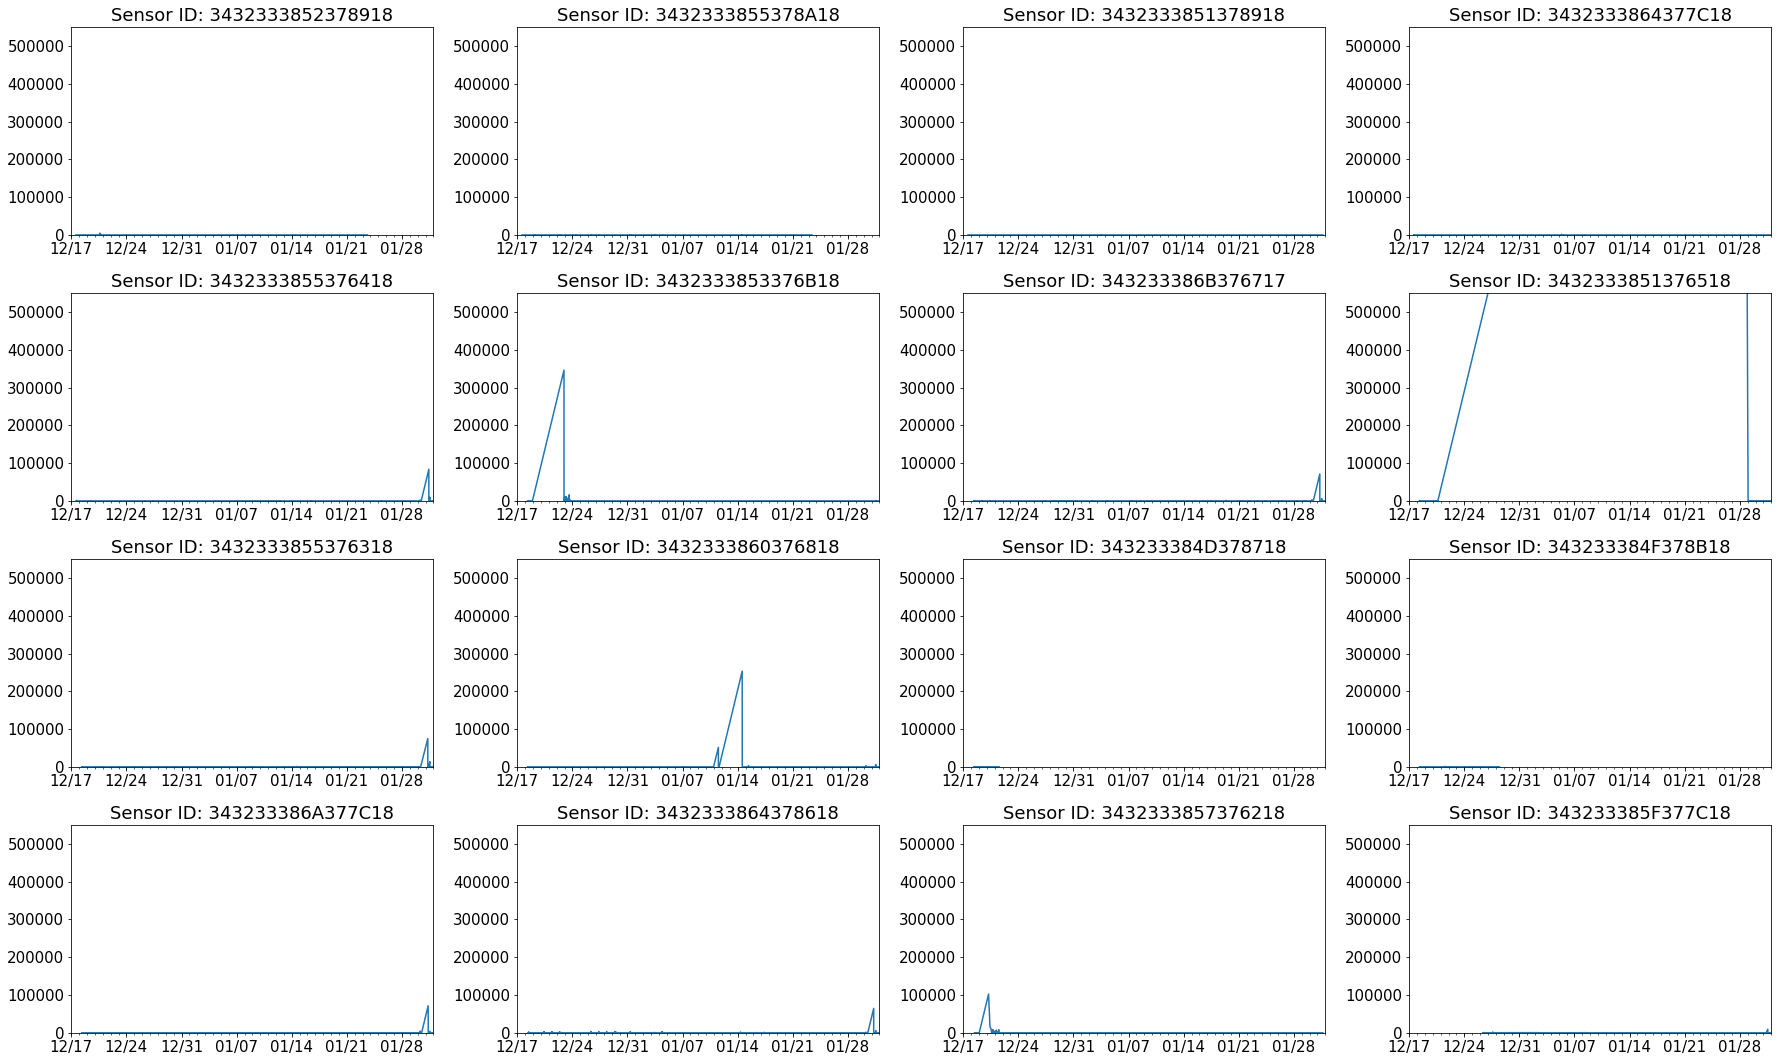

In [25]:
import datetime

categories = df_['device'].unique()
# z = working_days[(working_days['working day'] == 1)]
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(25,15))

mondays = mdates.WeekdayLocator(mdates.MONDAY)        # major ticks on the mondays
alldays = mdates.DayLocator()
weeksFmt = mdates.DateFormatter('%m/%d')

for c,num in zip(categories, range(1,len(categories)+1)):
    df0=all_data[all_data['device']==c]
    ax = fig.add_subplot(4, 4, num)
    ax.plot(df0['rx_time'], df0[['IPT']])
    ax.set_title("Sensor ID: " + str(c))
    ax.set_xlim([datetime.date(2018, 12, 17), datetime.date(2019, 2, 1)])
    ax.set_ylim(0,550000)

    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weeksFmt)
    
    # Plot working days
    #for xc in z.date.values:
    #    plt.axvline(x=xc, color='r', linestyle='-')

plt.tight_layout()
# plt.savefig(r'C:\Users\JeffG\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air\Results' + '/metadata_IPT_time.png')
# plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air\Results' + '/metadata_IPT_time_merged.png')
plt.show()

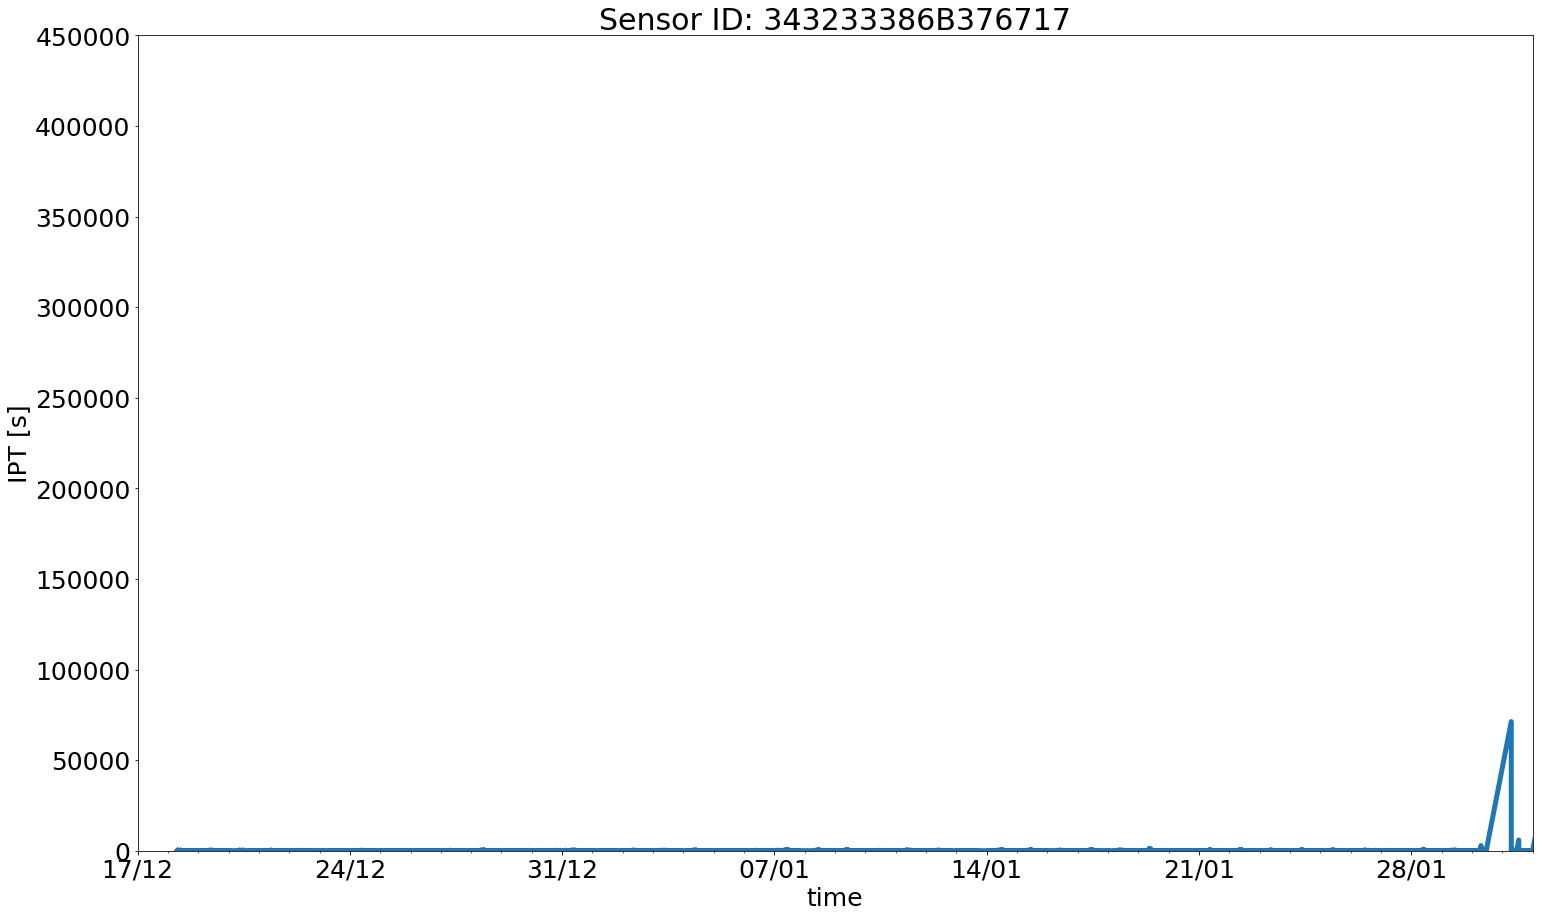

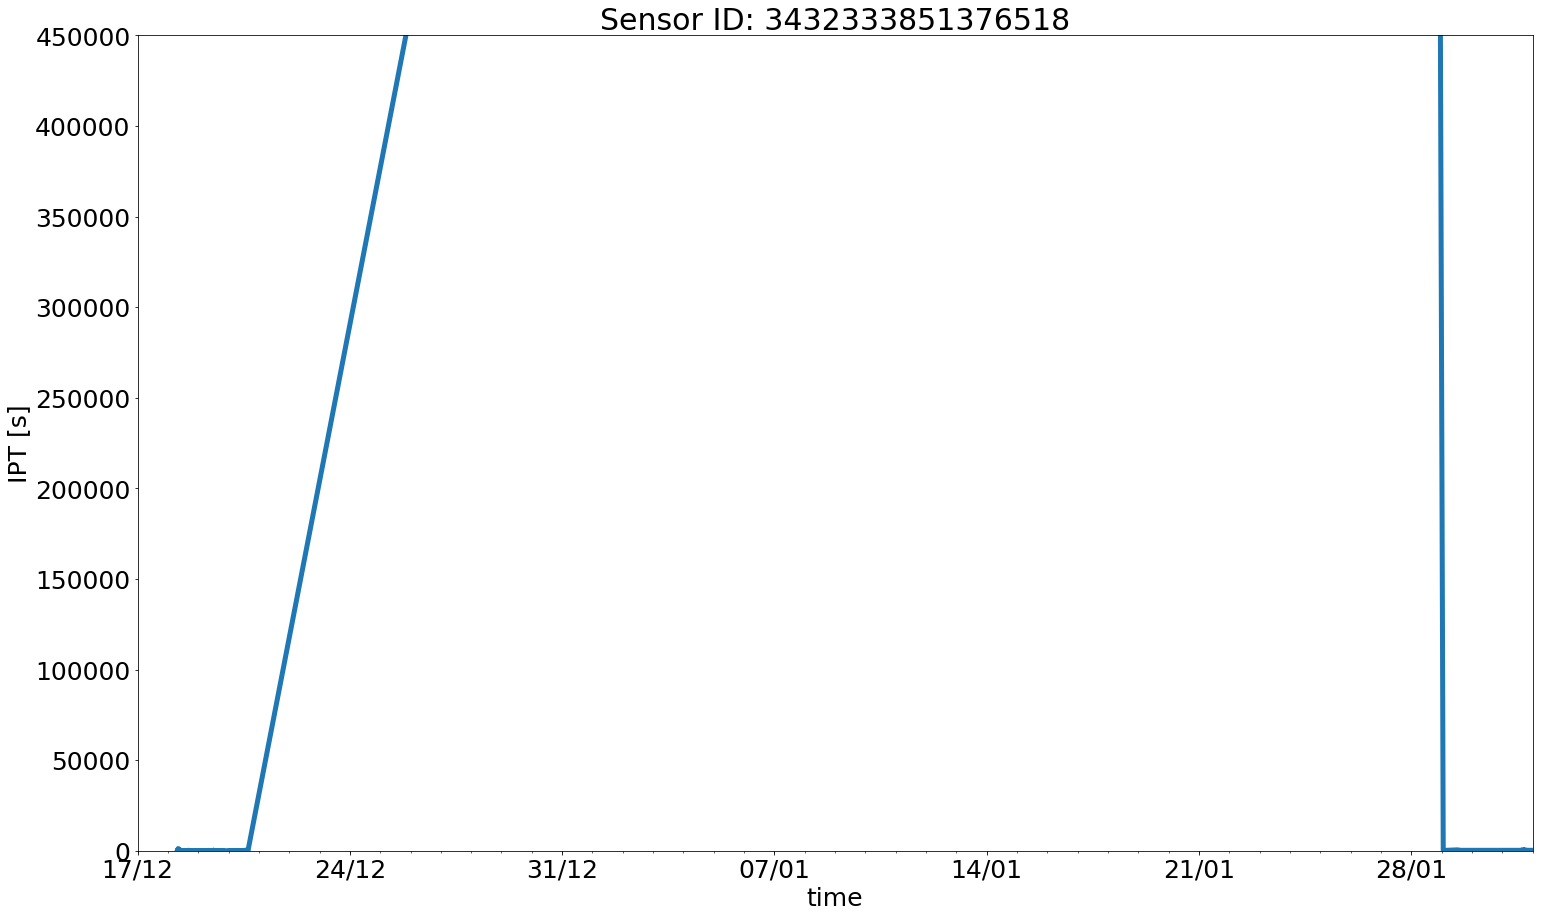

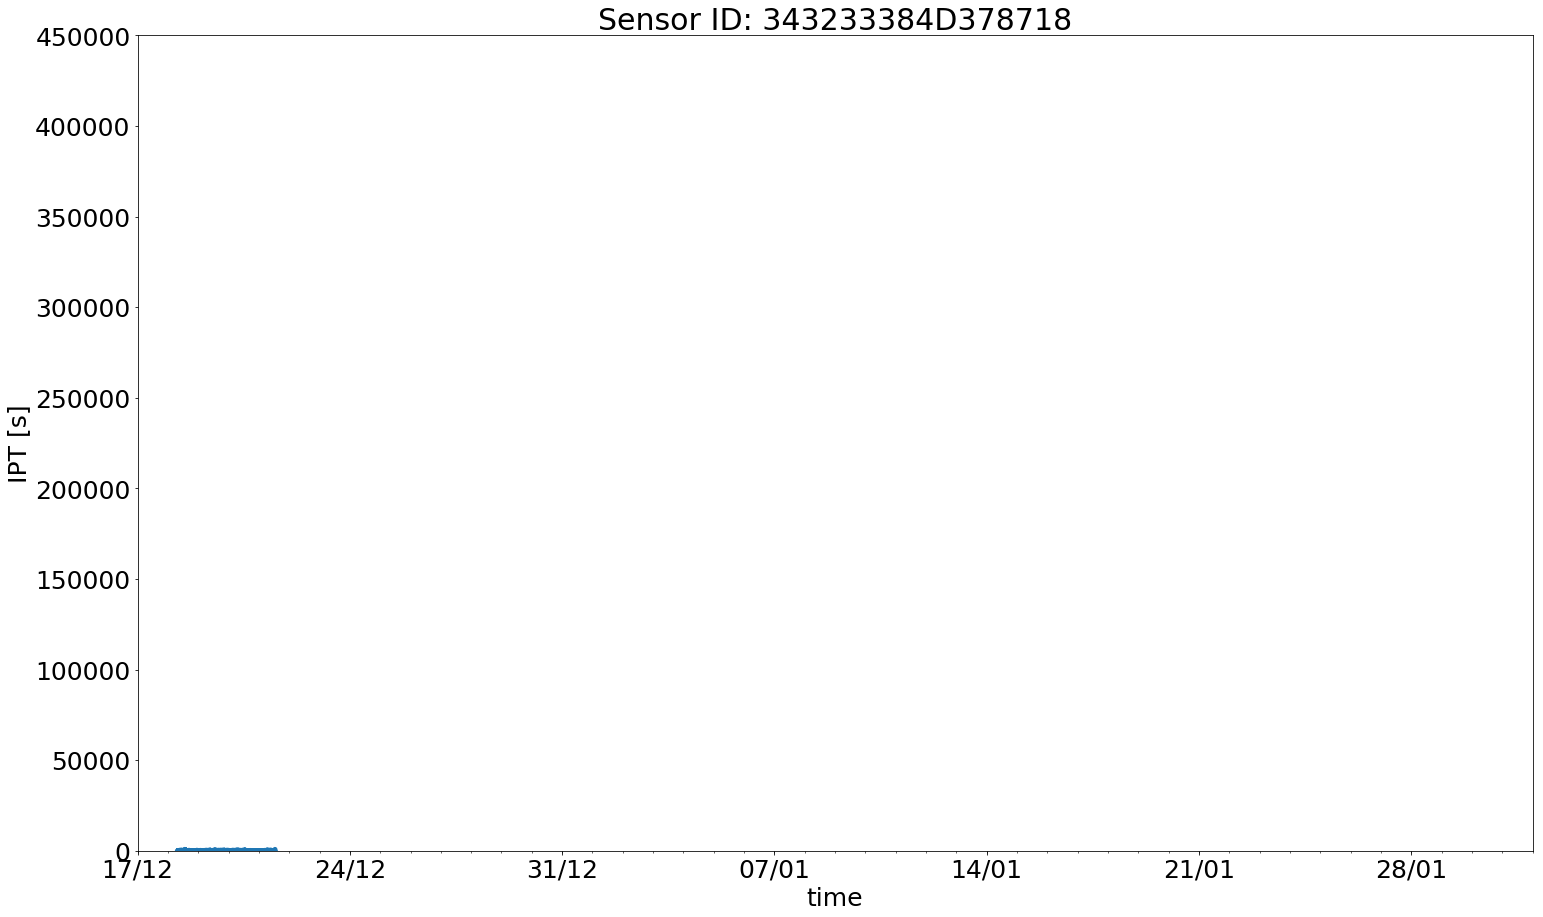

In [28]:
cs = ['343233386B376717','3432333851376518','343233384D378718']
plt.rcParams.update({'font.size': 25})

for c in cs:
    fig = plt.figure(figsize=(25,15))

    mondays = mdates.WeekdayLocator(mdates.MONDAY)        # major ticks on the mondays
    alldays = mdates.DayLocator()
    weeksFmt = mdates.DateFormatter('%d/%m')

    df0=all_data[all_data['device']==c]

    plt.title("Sensor ID: " + str(c))
    plt.xlim([datetime.date(2018, 12, 17), datetime.date(2019, 2, 1)])
    plt.ylim(0,450000)
    plt.ylabel('IPT [s]')
    plt.xlabel('time')

    plt.gca().xaxis.set_major_locator(mondays)
    plt.gca().xaxis.set_minor_locator(alldays)
    plt.gca().xaxis.set_major_formatter(weeksFmt)

    plt.plot(df0['rx_time'], df0[['IPT']],linewidth=5)
    plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air\Results\Data exploration'+'/CH4_IPT_time_merged_'+str(c)+'.png')

In [23]:
IPT_30_filt = all_data[all_data['IPT']<30]

In [24]:
IPT_30_filt.groupby(['spfact'])['IPT'].describe(percentiles=[0.125,0.25,0.375,0.50,0.625,0.750,0.875,0.95])

,count,mean,std,min,12.5%,25%,37.5%,50%,62.5%,75%,87.5%,95%,max
spfact,,,,,,,,,,,,,
7.0,271.0,17.420664,6.734116,0.0,11.0,12.0,14.0,18.0,21.0,22.0,25.25,28.0,29.0
8.0,325.0,18.532308,7.898842,1.0,8.5,13.0,18.0,21.0,22.0,25.0,27.00,28.8,29.0
9.0,905.0,19.285083,7.958441,1.0,8.0,14.0,19.0,22.0,24.0,26.0,27.00,28.0,29.0
10.0,1690.0,22.482249,7.513318,1.0,11.0,21.0,26.0,26.0,27.0,27.0,27.00,28.0,29.0
11.0,707.0,21.939180,7.641617,2.0,10.0,18.0,23.0,26.0,27.0,27.0,28.00,28.0,29.0
12.0,376.0,16.281915,7.768675,3.0,6.0,10.0,12.0,15.0,21.0,22.0,27.00,28.0,29.0


## Check if PM1 is missing at high SPF

In [64]:
PM1_SF_meta = pd.DataFrame(columns=['device', 'Missing PM1', 'Matches in meta','Matches %', 'SF7', 'SF8', 'SF9', 'SF10', 'SF11', 'SF12'])
for thingID in device_ids:
    # Load metadata for the device and calculate first and last timestamp
    df_1 = df[df['device']== thingID]
    first_timestamp = df_1.iloc[0].rx_time; #print(first_timestamp)
    last_timestamp = df_1.iloc[-1].rx_time; #print(last_timestamp)
    
    # Load NO2 measurement data and filter on timestamp
    raw_data_no2 = pd.read_csv(r'D:\Documents\Thesis\Case 2 - data\data\lora.' + str(thingID) +'\\lora.'+str(thingID) +'_' + 'airquality.no2' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
    raw_data_no2['time'] = pd.to_datetime(raw_data_no2['time'], unit='ms')
    raw_data_no2 = raw_data_no2[(raw_data_no2['time']>first_timestamp) & (raw_data_no2['time']<last_timestamp)]
    # Load PM1 measurement data and filter on timestamp
    raw_data_pm1 = pd.read_csv(r'D:\Documents\Thesis\Case 2 - data\data\lora.' + str(thingID) +'\\lora.'+str(thingID) +'_' + 'airquality.pm1' +'_Belair'+'.csv').drop(columns=['Unnamed: 0'])
    raw_data_pm1['time'] = pd.to_datetime(raw_data_pm1['time'], unit='ms')
    raw_data_pm1 = raw_data_pm1[(raw_data_pm1['time']>first_timestamp) & (raw_data_pm1['time']<last_timestamp)]
    
    # Filter the common timestamps
    common = raw_data_pm1.merge(raw_data_no2,on=['time','time'])
    
    # Filter the timestamps that occur in NO2 but not in PM1, this is where PM1 is missing
    missing_pm1 = raw_data_no2[(~raw_data_no2['time'].isin(common['time']))]
    
    # Merge the missing PM1 with the metadata to get the SF for those timestamps that we know it
    common_meta = missing_pm1.merge(df, left_on='time', right_on='rx_time', how='inner')
    common_count = common_meta.groupby(['spfact']).count()
    common_count = common_count.reindex(range(7,13), fill_value=0)
    # Generate results
    PM1_SF_meta = PM1_SF_meta.append({'device': thingID,
                            'Missing PM1': len(missing_pm1),
                            'Matches in meta': len(common_meta),
                            'Matches %': len(common_meta)/len(missing_pm1)*100,
                            'SF7': common_count.iloc[0][0], 
                            'SF8': common_count.iloc[1][0], 
                            'SF9': common_count.iloc[2][0], 
                            'SF10': common_count.iloc[3][0], 
                            'SF11': common_count.iloc[4][0], 
                            'SF12': common_count.iloc[5][0]}, ignore_index=True)

PM1_SF_meta

,device,Missing PM1,Matches in meta,Matches %,SF7,SF8,SF9,SF10,SF11,SF12
0,3432333852378918,371,315,84.905660,0,2,8,181,92,32
1,3432333864377C18,2678,671,25.056012,2,3,11,498,97,60
2,3432333851378918,1131,608,53.757737,1,4,17,396,152,38
3,3432333855378A18,24025,1206,5.019771,5,8,39,676,366,112
4,3432333855376418,6276,2223,35.420650,1,5,60,1300,713,144
5,343233386B376717,21142,3231,15.282376,2,6,47,1236,1008,932
6,343233386A377C18,1076,960,89.219331,0,3,25,708,208,16
7,3432333853376B18,245,153,62.448980,0,0,7,114,31,1
8,343233384F378B18,9238,947,10.251137,4,3,25,332,318,265
9,3432333860376818,150,107,71.333333,0,0,2,90,15,0


In [65]:
print(PM1_SF_meta.to_latex())

\begin{tabular}{llllrllllll}
\toprule
{} &            device & Missing PM1 & Matches in meta &  Matches \% & SF7 & SF8 & SF9 &  SF10 &  SF11 & SF12 \\
\midrule
0  &  3432333852378918 &         371 &             315 &  84.905660 &   0 &   2 &   8 &   181 &    92 &   32 \\
1  &  3432333864377C18 &        2678 &             671 &  25.056012 &   2 &   3 &  11 &   498 &    97 &   60 \\
2  &  3432333851378918 &        1131 &             608 &  53.757737 &   1 &   4 &  17 &   396 &   152 &   38 \\
3  &  3432333855378A18 &       24025 &            1206 &   5.019771 &   5 &   8 &  39 &   676 &   366 &  112 \\
4  &  3432333855376418 &        6276 &            2223 &  35.420650 &   1 &   5 &  60 &  1300 &   713 &  144 \\
5  &  343233386B376717 &       21142 &            3231 &  15.282376 &   2 &   6 &  47 &  1236 &  1008 &  932 \\
6  &  343233386A377C18 &        1076 &             960 &  89.219331 &   0 &   3 &  25 &   708 &   208 &   16 \\
7  &  3432333853376B18 &         245 &             153 &

# Anomaly detection

## Static threshold

In [79]:
all_data_stats = all_data.groupby(['spfact'])['IPT'].describe(percentiles=[0.25,0.50,0.75,0.85,0.90,0.95,0.99,0.995])
all_data_stats

,count,mean,std,min,25%,50%,75%,85%,90%,95%,99%,99.5%,max
spfact,,,,,,,,,,,,,
7.0,86369.0,62.469462,648.152636,0.0,31.0,31.0,31.0,63.0,63.0,126.00,505.00,790.00,75732.0
8.0,11857.0,61.435439,321.835776,1.0,31.0,31.0,32.0,63.0,69.0,126.00,487.32,853.44,29366.0
9.0,8741.0,72.402586,954.246591,1.0,31.0,31.0,51.0,63.0,66.0,125.00,445.00,948.00,83730.0
10.0,6425.0,103.205136,1590.577445,1.0,29.0,38.0,66.0,70.0,107.0,142.80,513.76,1031.88,78676.0
11.0,3672.0,109.119553,251.777775,2.0,35.0,88.0,135.0,149.0,154.0,262.45,595.00,987.03,9707.0
12.0,2450.0,310.077959,2118.896801,3.0,88.0,160.0,263.0,265.0,280.0,529.00,1928.22,2909.55,59785.0


### Static threshold based on 95% percentile

In [86]:
SF7_static_threshold = all_data_stats.iloc[0][9]; print(SF7_static_threshold)
SF8_static_threshold = all_data_stats.iloc[1][9]; print(SF8_static_threshold)
SF9_static_threshold = all_data_stats.iloc[2][9]; print(SF9_static_threshold)
SF10_static_threshold = all_data_stats.iloc[3][9]; print(SF10_static_threshold)
SF11_static_threshold = all_data_stats.iloc[4][9]; print(SF11_static_threshold)
SF12_static_threshold = all_data_stats.iloc[5][9]; print(SF12_static_threshold)

126.0
126.0
125.0
142.79999999999927
262.4499999999998
529.0


In [87]:
anomalies_static = all_data[((all_data['spfact']==7) & (all_data['IPT']>SF7_static_threshold)) |
                             ((all_data['spfact']==8) & (all_data['IPT']>SF8_static_threshold))|
                             ((all_data['spfact']==9) & (all_data['IPT']>SF9_static_threshold))|
                             ((all_data['spfact']==10) & (all_data['IPT']>SF10_static_threshold))|
                             ((all_data['spfact']==11) & (all_data['IPT']>SF11_static_threshold))|
                             ((all_data['spfact']==12) & (all_data['IPT']>SF12_static_threshold))]

In [88]:
len(anomalies_static)

5216

### Static threshold based on first filtering on 95% percentile and then calculating mean and std

In [89]:
all_data_filtered = all_data[((all_data['spfact']==7) & (all_data['IPT']<SF7_static_threshold)) |
                             ((all_data['spfact']==8) & (all_data['IPT']<SF8_static_threshold))|
                             ((all_data['spfact']==9) & (all_data['IPT']<SF9_static_threshold))|
                             ((all_data['spfact']==10) & (all_data['IPT']<SF10_static_threshold))|
                             ((all_data['spfact']==11) & (all_data['IPT']<SF11_static_threshold))|
                             ((all_data['spfact']==12) & (all_data['IPT']<SF12_static_threshold))]

In [90]:
filtered_stats = all_data_filtered.groupby(['spfact'])['IPT'].describe(percentiles=[0.25,0.50,0.75,0.85,0.90,0.95,0.99,0.995])
filtered_stats

,count,mean,std,min,25%,50%,75%,85%,90%,95%,99%,99.5%,max
spfact,,,,,,,,,,,,,
7.0,81774.0,36.090799,14.147726,0.0,31.0,31.0,31.0,32.0,63.0,63.0,95.00,95.00,125.0
8.0,11184.0,38.404328,17.229824,1.0,31.0,31.0,32.0,63.0,63.0,64.0,95.00,95.00,125.0
9.0,8299.0,38.310037,17.644754,1.0,31.0,31.0,38.0,63.0,63.0,66.0,95.00,102.51,124.0
10.0,6103.0,45.670818,26.871191,1.0,28.0,38.0,63.0,66.0,71.0,108.0,132.00,135.00,142.0
11.0,3488.0,83.311640,55.185747,2.0,33.0,70.0,122.0,148.0,149.0,158.0,244.26,257.00,262.0
12.0,2320.0,159.680603,106.336871,3.0,76.0,155.0,254.0,264.0,265.0,280.0,512.05,528.00,528.0


In [91]:
mean_7 = filtered_stats.iloc[0][1]
std_7 = filtered_stats.iloc[0][2]
mean_8 = filtered_stats.iloc[1][1]
std_8 = filtered_stats.iloc[1][2]
mean_9 = filtered_stats.iloc[2][1]
std_9 = filtered_stats.iloc[2][2]
mean_10 = filtered_stats.iloc[3][1]
std_10 = filtered_stats.iloc[3][2]
mean_11 = filtered_stats.iloc[4][1]
std_11 = filtered_stats.iloc[4][2]
mean_12 = filtered_stats.iloc[5][1]
std_12 = filtered_stats.iloc[5][2]

SF7_static_threshold_std = mean_7+3*std_7
SF8_static_threshold_std = mean_8+3*std_8
SF9_static_threshold_std = mean_9+3*std_9
SF10_static_threshold_std = mean_10+3*std_10
SF11_static_threshold_std = mean_11+3*std_11
SF12_static_threshold_std = mean_12+3*std_12

print('SF7 threshold: ' + str(SF7_static_threshold_std))
print('SF8 threshold: ' + str(SF8_static_threshold_std))
print('SF9 threshold: ' + str(SF9_static_threshold_std))
print('SF10 threshold: ' + str(SF10_static_threshold_std))
print('SF11 threshold: ' + str(SF11_static_threshold_std))
print('SF12 threshold: ' + str(SF12_static_threshold_std))

SF7 threshold: 78.53397746947977
SF8 threshold: 90.09379816245388
SF9 threshold: 91.24429930980261
SF10 threshold: 126.28439086561235
SF11 threshold: 248.8688806146772
SF12 threshold: 478.6912161212947


In [92]:
anomalies_static_std = all_data[((all_data['spfact']==7) & (all_data['IPT']>SF7_static_threshold_std)) |
                             ((all_data['spfact']==8) & (all_data['IPT']>SF8_static_threshold_std))|
                             ((all_data['spfact']==9) & (all_data['IPT']>SF9_static_threshold_std))|
                             ((all_data['spfact']==10) & (all_data['IPT']>SF10_static_threshold_std))|
                             ((all_data['spfact']==11) & (all_data['IPT']>SF11_static_threshold_std))|
                             ((all_data['spfact']==12) & (all_data['IPT']>SF12_static_threshold_std))]

In [96]:
anomalies_static_std.groupby(['spfact'])['IPT'].describe(percentiles=[0.25,0.50,0.75,0.85,0.90,0.95,0.99,0.995])

,count,mean,std,min,25%,50%,75%,85%,90%,95%,99%,99.5%,max
spfact,,,,,,,,,,,,,
7.0,6963.0,383.499066,2257.966427,81.0,95.0,157.0,284.00,442.00,599.8,885.0,2794.02,5134.590,75732.0
8.0,1168.0,296.834760,994.711482,93.0,94.0,126.0,221.00,347.00,504.0,854.0,3033.33,4105.345,29366.0
9.0,726.0,471.731405,3286.484436,92.0,95.0,126.0,252.00,379.00,549.5,1099.5,5084.00,6365.875,83730.0
10.0,470.0,859.561702,5833.320716,127.0,135.0,148.0,259.75,474.65,673.1,1303.6,6435.92,50624.510,78676.0
11.0,213.0,551.760563,918.016157,249.0,264.0,298.0,447.00,718.60,897.4,1332.2,3326.80,7299.460,9707.0
12.0,161.0,2517.285714,7958.337551,483.0,529.0,713.0,1346.00,1939.00,2585.0,5544.0,52557.80,54870.600,59785.0


In [97]:
len(anomalies_static_std)

9701

In [98]:
len(anomalies_static_std)/len(all_data)

0.008268738695583243

## Unsupervised learning - DBSCAN

### Import libraries

In [44]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

### Select data

In [50]:
# Select features
df_ftrs = all_data[['spfact', 'IPT']]
X = all_data[['spfact', 'IPT']]

# Normalize interpacket times
X['IPT']=df_ftrs.groupby('spfact').transform(lambda x: (x - x.min()) / (x.max()-x.min()))

# Take 10k samples since more is difficult to calculate the DBSCAN
Xnew = X.values
X = X.sample(10000).values


labels_true = X[:,0]

C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Define DBSCAN

In [52]:
def perform_dbscan(X, n_eps, n_min_samples):
    # Compute DBSCAN
    db = DBSCAN(eps=n_eps, min_samples=n_min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
#     print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#     print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#     print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#     print("Adjusted Rand Index: %0.3f"
#           % metrics.adjusted_rand_score(labels_true, labels))
#     print("Adjusted Mutual Information: %0.3f"
#           % metrics.adjusted_mutual_info_score(labels_true, labels))
#     print("Silhouette Coefficient: %0.3f"
#           % metrics.silhouette_score(X, labels))
    
    return db, core_samples_mask, n_clusters_, n_noise_

### Define plotting function

In [57]:
def plot_dbscan(X, labels, core_samples_mask, title, n_eps, n_min_smaples):
    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title(title)
    plt.tight_layout()
    plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 2 - Bel-Air\Results\DBSCAN_2D' + '/DBSCAN_2D_{}_{}.png'.format(n_eps, n_min_samples), dpi=(200), bbox_inches="tight")
    plt.show()

### Run different configurations to find the right parameters

Estimated number of clusters: 8
Estimated number of noise points: 70


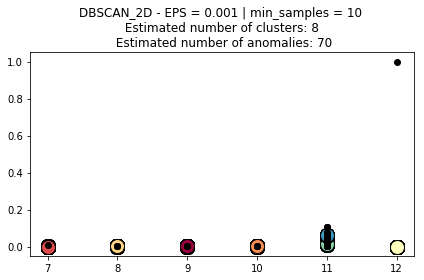

Estimated number of clusters: 7
Estimated number of noise points: 122


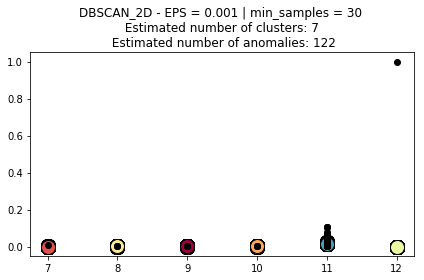

Estimated number of clusters: 6
Estimated number of noise points: 179


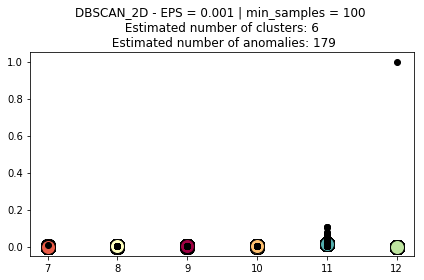

Estimated number of clusters: 4
Estimated number of noise points: 608


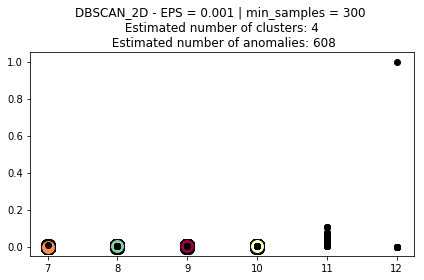

Estimated number of clusters: 9
Estimated number of noise points: 19


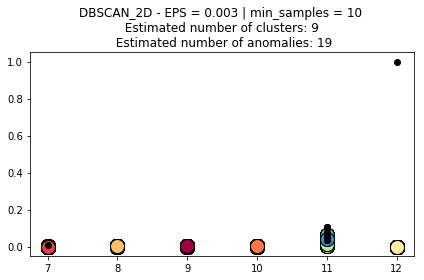

Estimated number of clusters: 7
Estimated number of noise points: 64


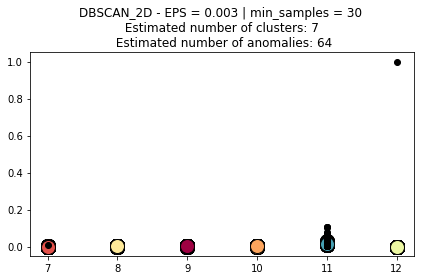

Estimated number of clusters: 6
Estimated number of noise points: 121


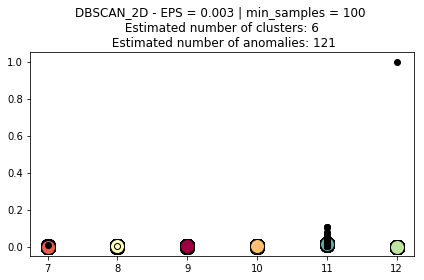

Estimated number of clusters: 4
Estimated number of noise points: 599


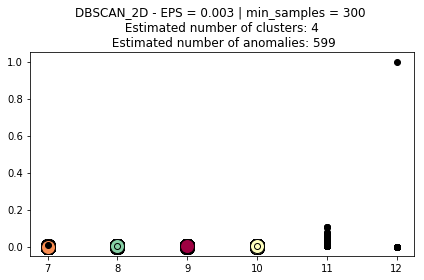

Estimated number of clusters: 6
Estimated number of noise points: 5


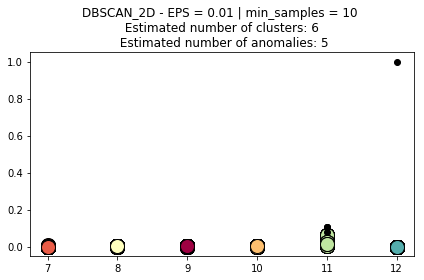

Estimated number of clusters: 7
Estimated number of noise points: 6


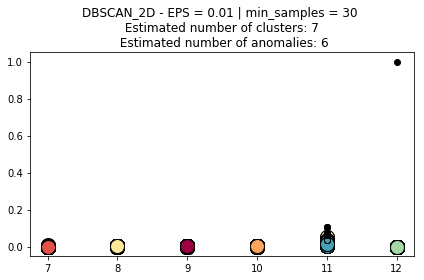

Estimated number of clusters: 6
Estimated number of noise points: 49


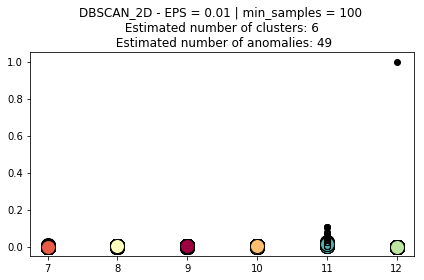

Estimated number of clusters: 5
Estimated number of noise points: 279


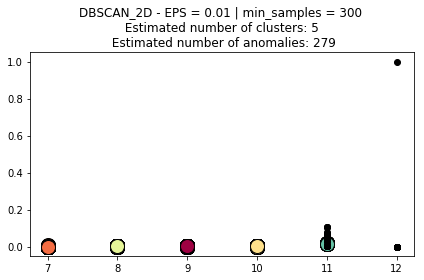

Estimated number of clusters: 6
Estimated number of noise points: 1


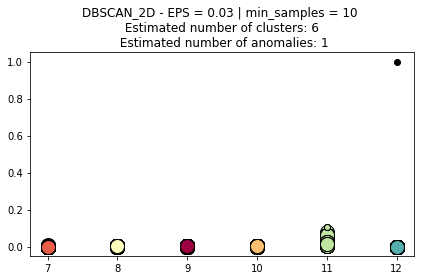

Estimated number of clusters: 6
Estimated number of noise points: 4


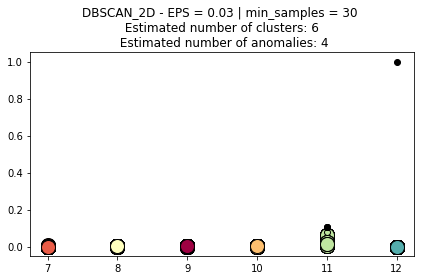

Estimated number of clusters: 6
Estimated number of noise points: 4


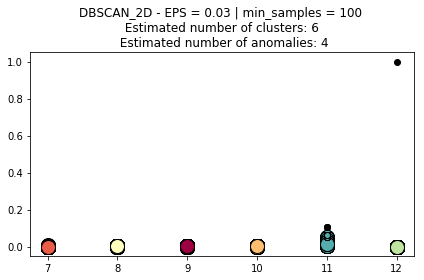

Estimated number of clusters: 5
Estimated number of noise points: 222


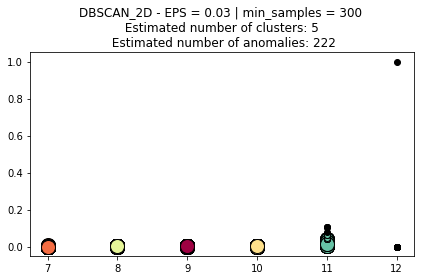

Estimated number of clusters: 6
Estimated number of noise points: 1


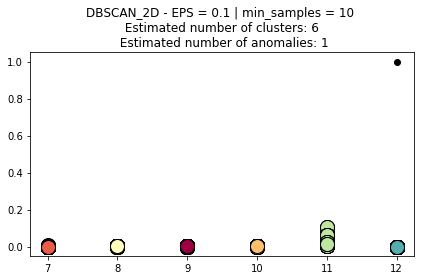

Estimated number of clusters: 6
Estimated number of noise points: 1


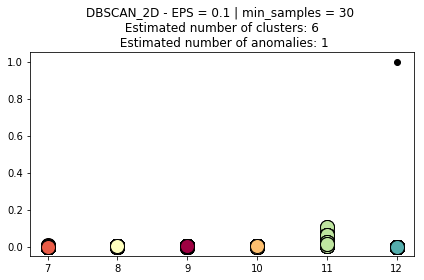

Estimated number of clusters: 6
Estimated number of noise points: 1


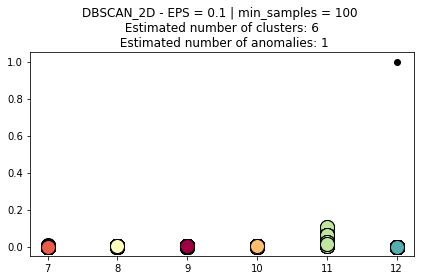

Estimated number of clusters: 5
Estimated number of noise points: 218


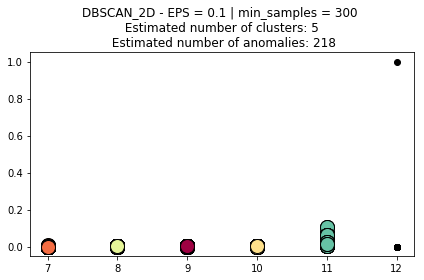

Estimated number of clusters: 6
Estimated number of noise points: 1


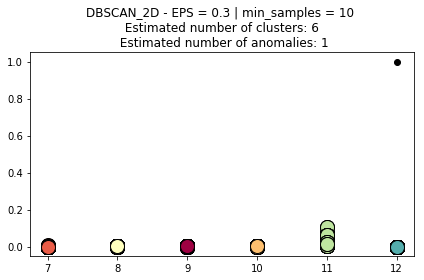

Estimated number of clusters: 6
Estimated number of noise points: 1


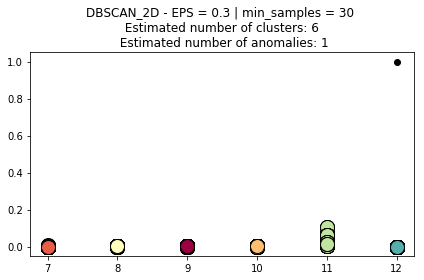

Estimated number of clusters: 6
Estimated number of noise points: 1


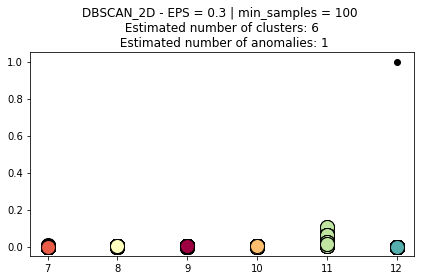

Estimated number of clusters: 5
Estimated number of noise points: 218


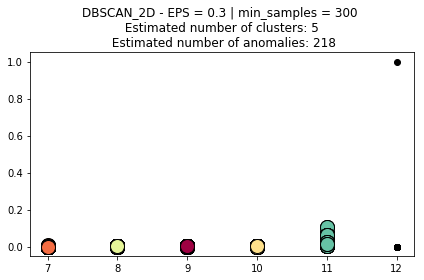

In [58]:
eps_ar = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
min_samples_ar = [10, 30, 100, 300]

# eps_ar = [0.03]
# min_samples_ar = [30]

result = pd.DataFrame(columns=['EPS', 'min_samples', 'Nr of clusters', 'Nr of anomalies'])

for n_eps in eps_ar:
    for n_min_samples in min_samples_ar:
        # Run DBSCAN
        db, core_samples_mask, n_clusters_, n_noise_ = perform_dbscan(X, n_eps, n_min_samples)
        
        # Plot and save result
        title = 'DBSCAN_2D - EPS = {} | min_samples = {} \n Estimated number of clusters: {} \n Estimated number of anomalies: {}'.format(n_eps ,n_min_samples, n_clusters_, n_noise_)
        plot_dbscan(X, db.labels_, core_samples_mask, title, n_eps, n_min_samples)
        
        result = result.append({'EPS': n_eps, 
                                'min_samples':n_min_samples, 
                                'Nr of clusters': n_clusters_, 
                                'Nr of anomalies': n_noise_}, ignore_index=True)

In [54]:
result

,EPS,min_samples,Nr of clusters,Nr of anomalies
0,0.001,10.0,8.0,70.0
1,0.001,30.0,7.0,122.0
2,0.001,100.0,6.0,179.0
3,0.001,300.0,4.0,608.0
4,0.003,10.0,9.0,19.0
5,0.003,30.0,7.0,64.0
6,0.003,100.0,6.0,121.0
7,0.003,300.0,4.0,599.0
8,0.010,10.0,6.0,5.0
9,0.010,30.0,7.0,6.0


### Final choice

In [59]:
# Final choice for 2D case:
# EPS = 0.01
# min_samples = 100

db, core_samples_mask, n_clusters_, n_noise_ = perform_dbscan(X, 0.01, 100)

Estimated number of clusters: 6
Estimated number of noise points: 49


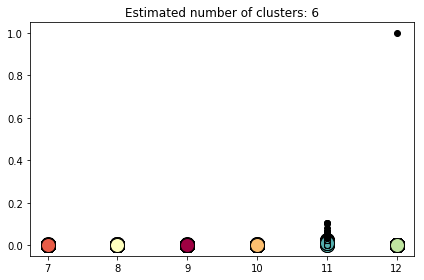

In [60]:
plot_dbscan(X, db.labels_, core_samples_mask, 'Estimated number of clusters: {}'.format(n_clusters_), 0.03, 30)

### Predict clusters on whole dataset

In [61]:
def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [62]:
prediction_labels = dbscan_predict(db,Xnew)
prediction_indices = np.where(prediction_labels!=-1)
nr_anomalies_ = sum(prediction_labels==-1)
prediction_mask = np.zeros_like(prediction_labels, dtype=bool)
prediction_mask[prediction_indices] = True

In [63]:
print(nr_anomalies_)

4800


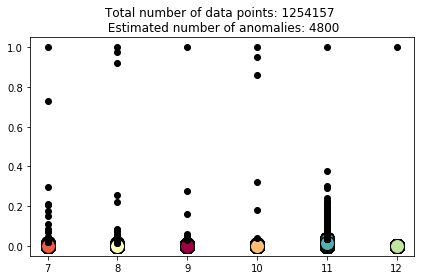

In [64]:
plot_dbscan(Xnew, prediction_labels, prediction_mask, 'Total number of data points: {} \n Estimated number of anomalies: {}'.format(len(prediction_labels), nr_anomalies_), 0.03, 30)